# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook  - ***13 points***
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework) 
- homework_differentiation.ipynb -  ***2 points***

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

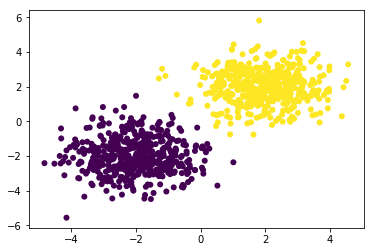

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

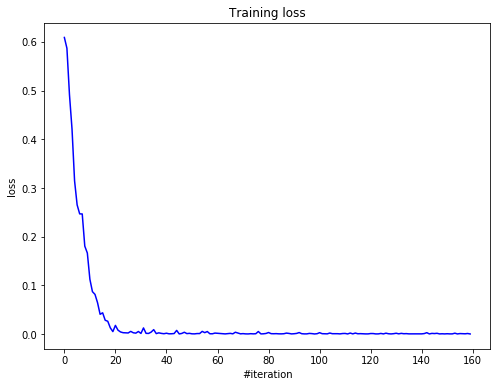

Current loss: 0.000047


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [9]:
# Your code goes here. ################################################
nb_classes = 10

def indices_to_one_hot(data, nb_classes):  
    # https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python by Martin Thoma
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]
y_train_enc = indices_to_one_hot(y_train, nb_classes)
y_val_enc = indices_to_one_hot(y_val, nb_classes)
y_test_enc = indices_to_one_hot(y_test, nb_classes)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison. Write your personal opinion on the activation functions, think about computation times too. Plot the losses both from activation functions comparison comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking. ***2.5 points***
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions. Plot the losses both for the `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.  Does `BatchNormalization` help? ***2.5 points***

- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better? ***2.5 points***
- Increase the number of parameters in the network. Try inserting the Dropout layer. Compare the validation performance and the gap between test and validation performances for the two experiments (with and without Dropout). Compare the loss plots. Which one converges slower? ***2.5 points***


### Part 1: Compare ReLU, ELU, LeakyReLU, SoftPlus activation functions

In [10]:
# Your code goes here. ################################################

criterion = ClassNLLCriterion()

test1 = Sequential()
test1.add(Flatten())
test1.add(Linear(784, 28))
test1.add(ReLU())
test1.add(Linear(28, 10))
test1.add(LogSoftMax())

test2 = Sequential()
test2.add(Flatten())
test2.add(Linear(784, 28))
test2.add(ELU())
test2.add(Linear(28, 10))
test2.add(LogSoftMax())

test3 = Sequential()
test3.add(Flatten())
test3.add(Linear(784, 28))
test3.add(LeakyReLU())
test3.add(Linear(28, 10))
test3.add(LogSoftMax())

test4 = Sequential()
test4.add(Flatten())
test4.add(Linear(784, 28))
test4.add(SoftPlus())
test4.add(Linear(28, 10))
test4.add(LogSoftMax())

In [11]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [12]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [13]:
from tqdm import tqdm
loss_history_1 = []

for i in tqdm(range(n_epoch)):
    for x_batch, y_batch in get_batches((X_train, y_train_enc), batch_size):
        
        test1.zeroGradParameters()
        
        # Forward
        predictions = test1.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        test1.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(test1.getParameters(), 
                     test1.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history_1.append(loss)
        
    y_pred_1 = np.argmax(test1.forward(X_test), axis=1)
    acc_1 = np.mean(y_pred_1 == y_test)

    # Visualize
    
print('Current loss: %f' % loss)
print('Accuracy: %f' % acc_1)

100%|██████████| 20/20 [00:07<00:00,  2.87it/s]

Current loss: 0.082463
Accuracy: 0.964400


In [14]:
loss_history_2 = []

for i in tqdm(range(n_epoch)):
    for x_batch, y_batch in get_batches((X_train, y_train_enc), batch_size):
        
        test2.zeroGradParameters()
        
        # Forward
        predictions = test2.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        test2.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(test2.getParameters(), 
                     test2.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history_2.append(loss)

    y_pred_2 = np.argmax(test2.forward(X_test), axis=1)
    acc_2 = np.mean(y_pred_2 == y_test)

    # Visualize
    
print('Current loss: %f' % loss)
print('Accuracy: %f' % acc_2)

100%|██████████| 20/20 [00:47<00:00,  2.50s/it]

Current loss: 0.106346
Accuracy: 0.964900


In [15]:
from tqdm import tqdm
loss_history_3 = []

for i in tqdm(range(n_epoch)):
    for x_batch, y_batch in get_batches((X_train, y_train_enc), batch_size):
        
        test3.zeroGradParameters()
        
        # Forward
        predictions = test3.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        test3.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(test3.getParameters(), 
                     test3.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history_3.append(loss)

    y_pred_3 = np.argmax(test3.forward(X_test), axis=1)
    acc_3 = np.mean(y_pred_3 == y_test)

    # Visualize
    
print('Current loss: %f' % loss)
print('Accuracy: %f' % acc_3)

100%|██████████| 20/20 [00:20<00:00,  1.03it/s]

Current loss: 0.040057
Accuracy: 0.964700


In [16]:
from tqdm import tqdm
loss_history_4 = []

for i in tqdm(range(n_epoch)):
    for x_batch, y_batch in get_batches((X_train, y_train_enc), batch_size):
        
        test4.zeroGradParameters()
        
        # Forward
        predictions = test4.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        test4.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(test4.getParameters(), 
                     test4.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history_4.append(loss)

    y_pred_4 = np.argmax(test4.forward(X_test), axis=1)
    acc_4 = np.mean(y_pred_4 == y_test)

    # Visualize
    
print('Current loss: %f' % loss)
print('Accuracy: %f' % acc_4)

100%|██████████| 20/20 [00:08<00:00,  2.27it/s]

Current loss: 0.021072
Accuracy: 0.963100


Everything on the single plot:

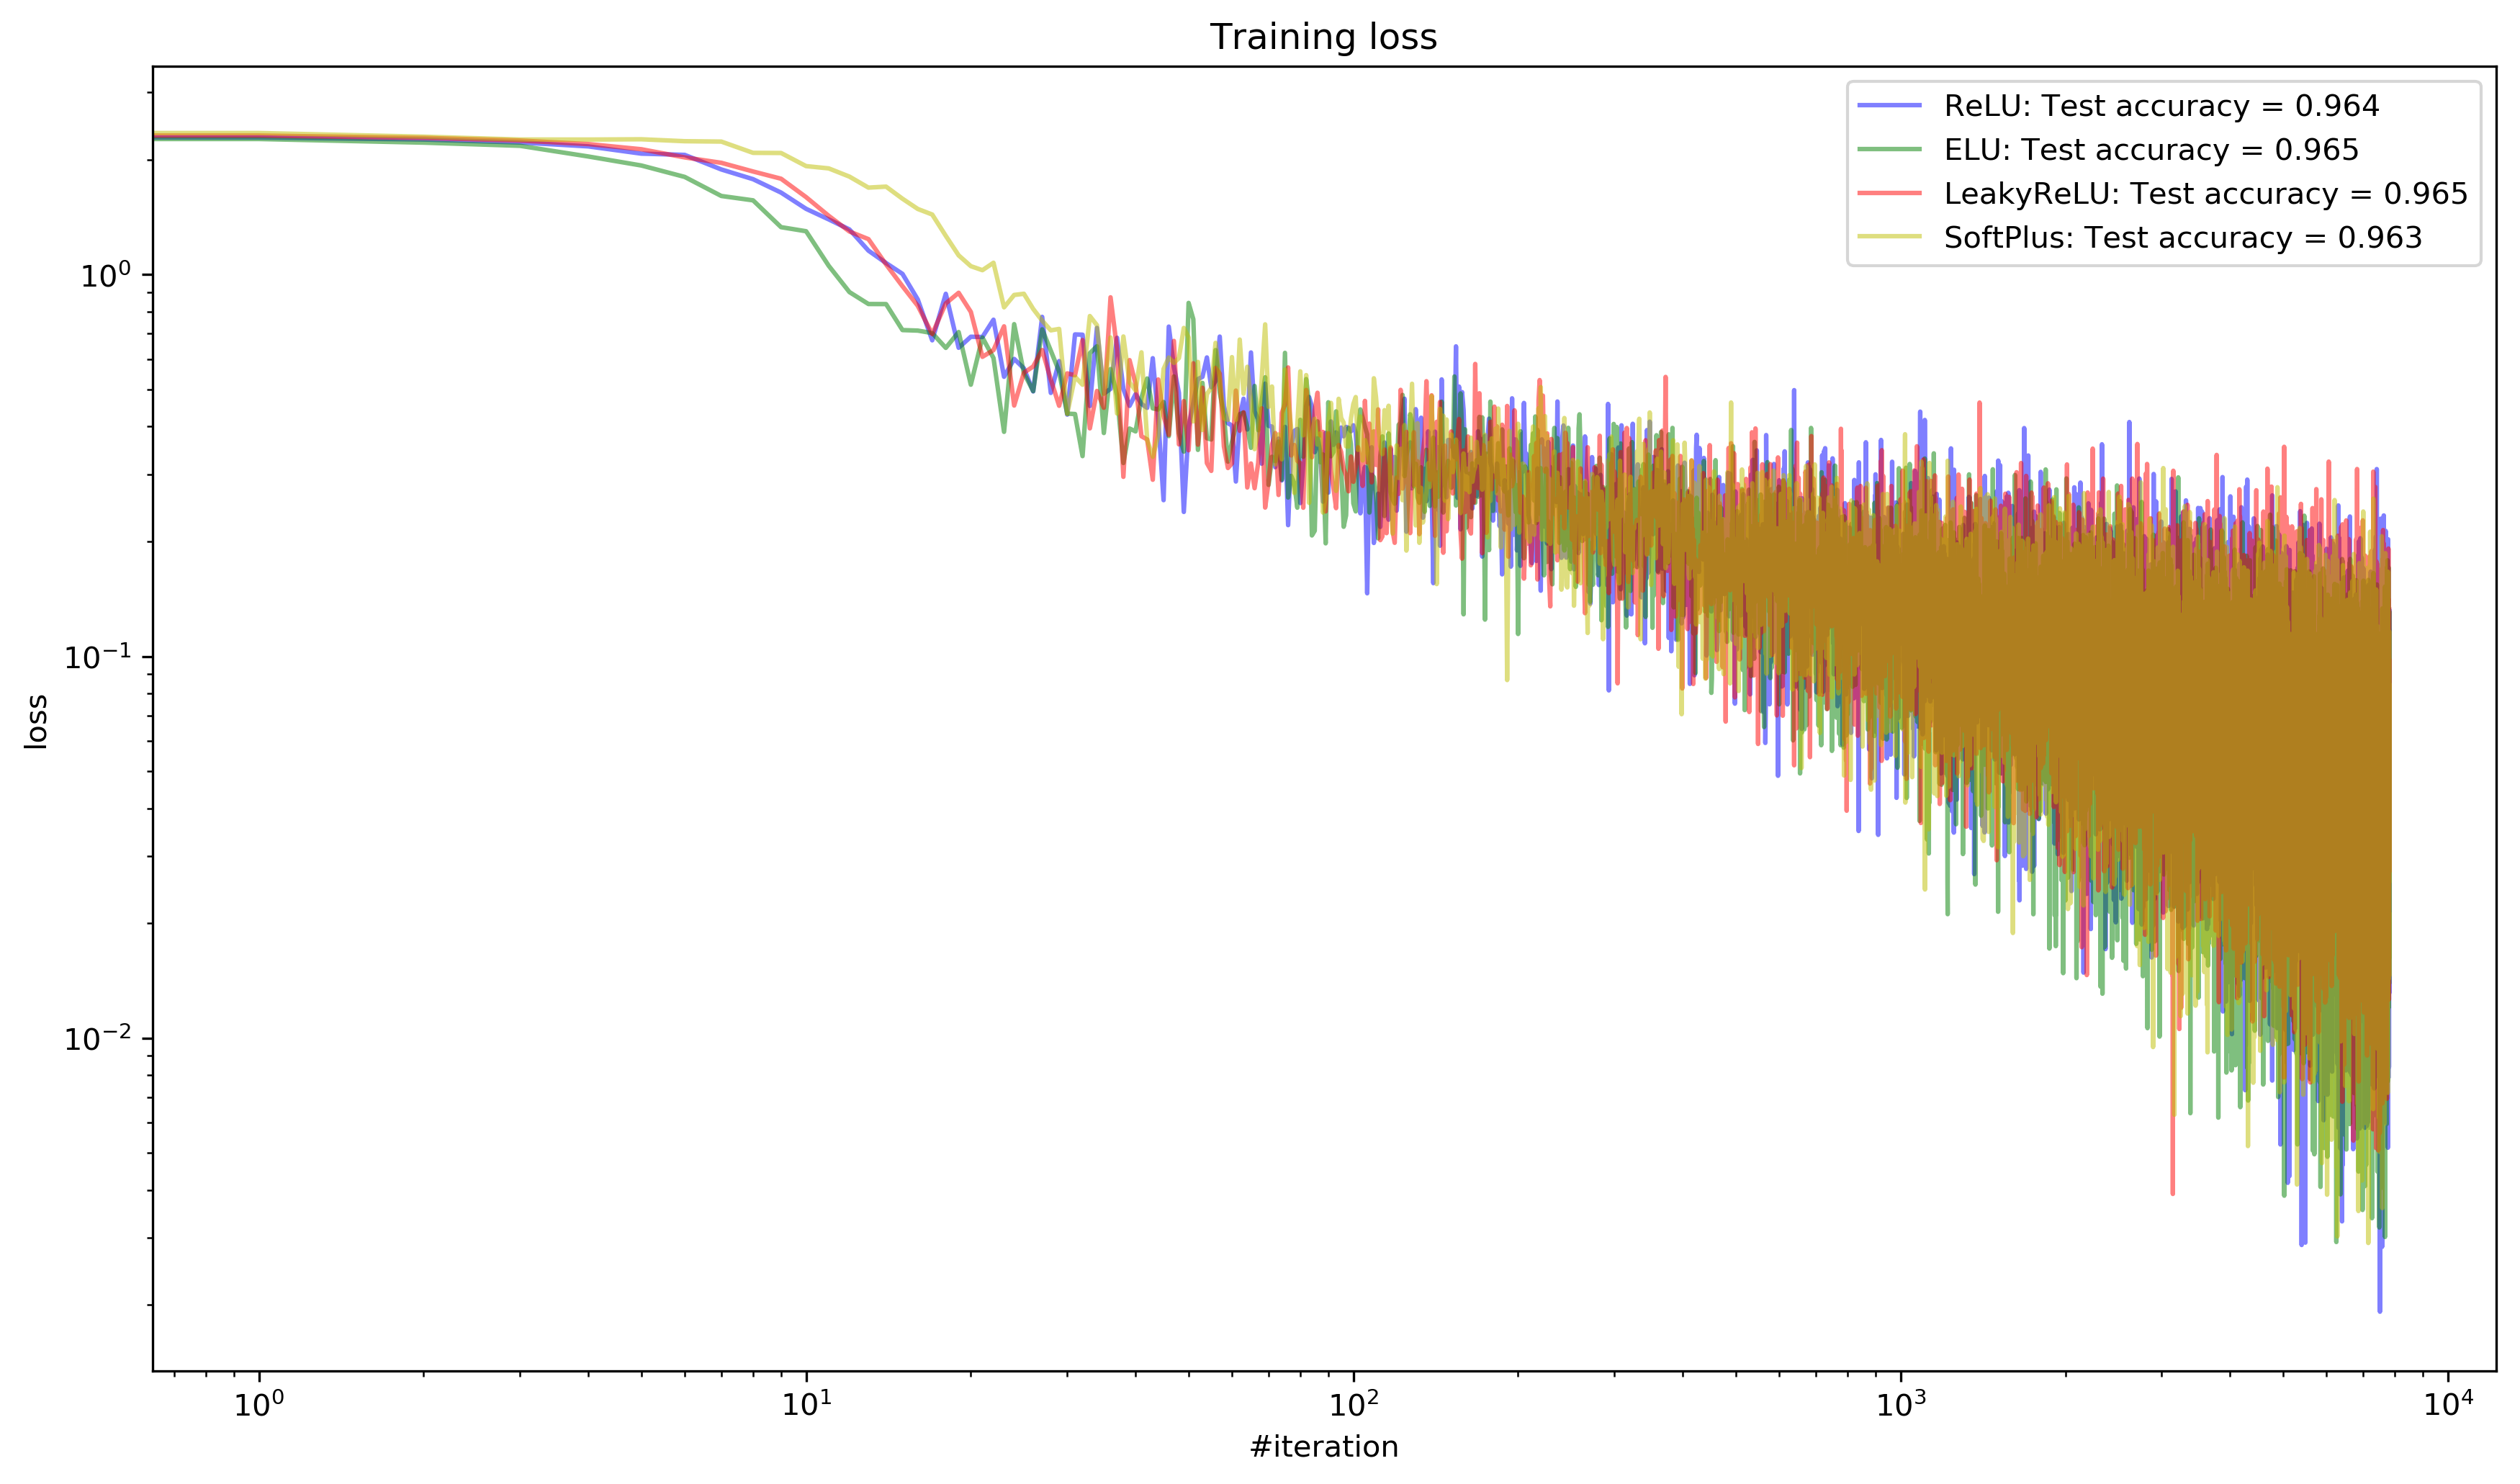

In [17]:
display.clear_output(wait=True)
plt.figure(figsize=(14, 8), dpi=300)
plt.yscale('log')
plt.xscale('log')
plt.plot(loss_history_1, 'b', label = 'ReLU: Test accuracy = %0.3f' % acc_1, alpha=0.5)
plt.plot(loss_history_2, 'g', label = 'ELU: Test accuracy = %0.3f' % acc_2, alpha=0.5)
plt.plot(loss_history_3, 'r', label = 'LeakyReLU: Test accuracy = %0.3f' % acc_3, alpha=0.5)
plt.plot(loss_history_4, 'y', label = 'SoftPlus: Test accuracy = %0.3f' % acc_4, alpha=0.5)
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.legend();

### Explanation of the Results

Based on results, the best test accuracy was for the SoftPlus, while LeakyReLU has the fastest iterations per epoch.

### Part 2: Try inserting BatchNormalization (folowed by ChannelwiseScaling) between Linear module and activation functions.

In [18]:
criterion = ClassNLLCriterion()

test5 = Sequential()
test5.add(Flatten())
test5.add(Linear(784, 28))
test5.add(BatchNormalization(alpha = 0.99))
test5.add(ChannelwiseScaling(28))
test5.add(ReLU())
test5.add(Linear(28, 10))
test5.add(LogSoftMax())

In [19]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

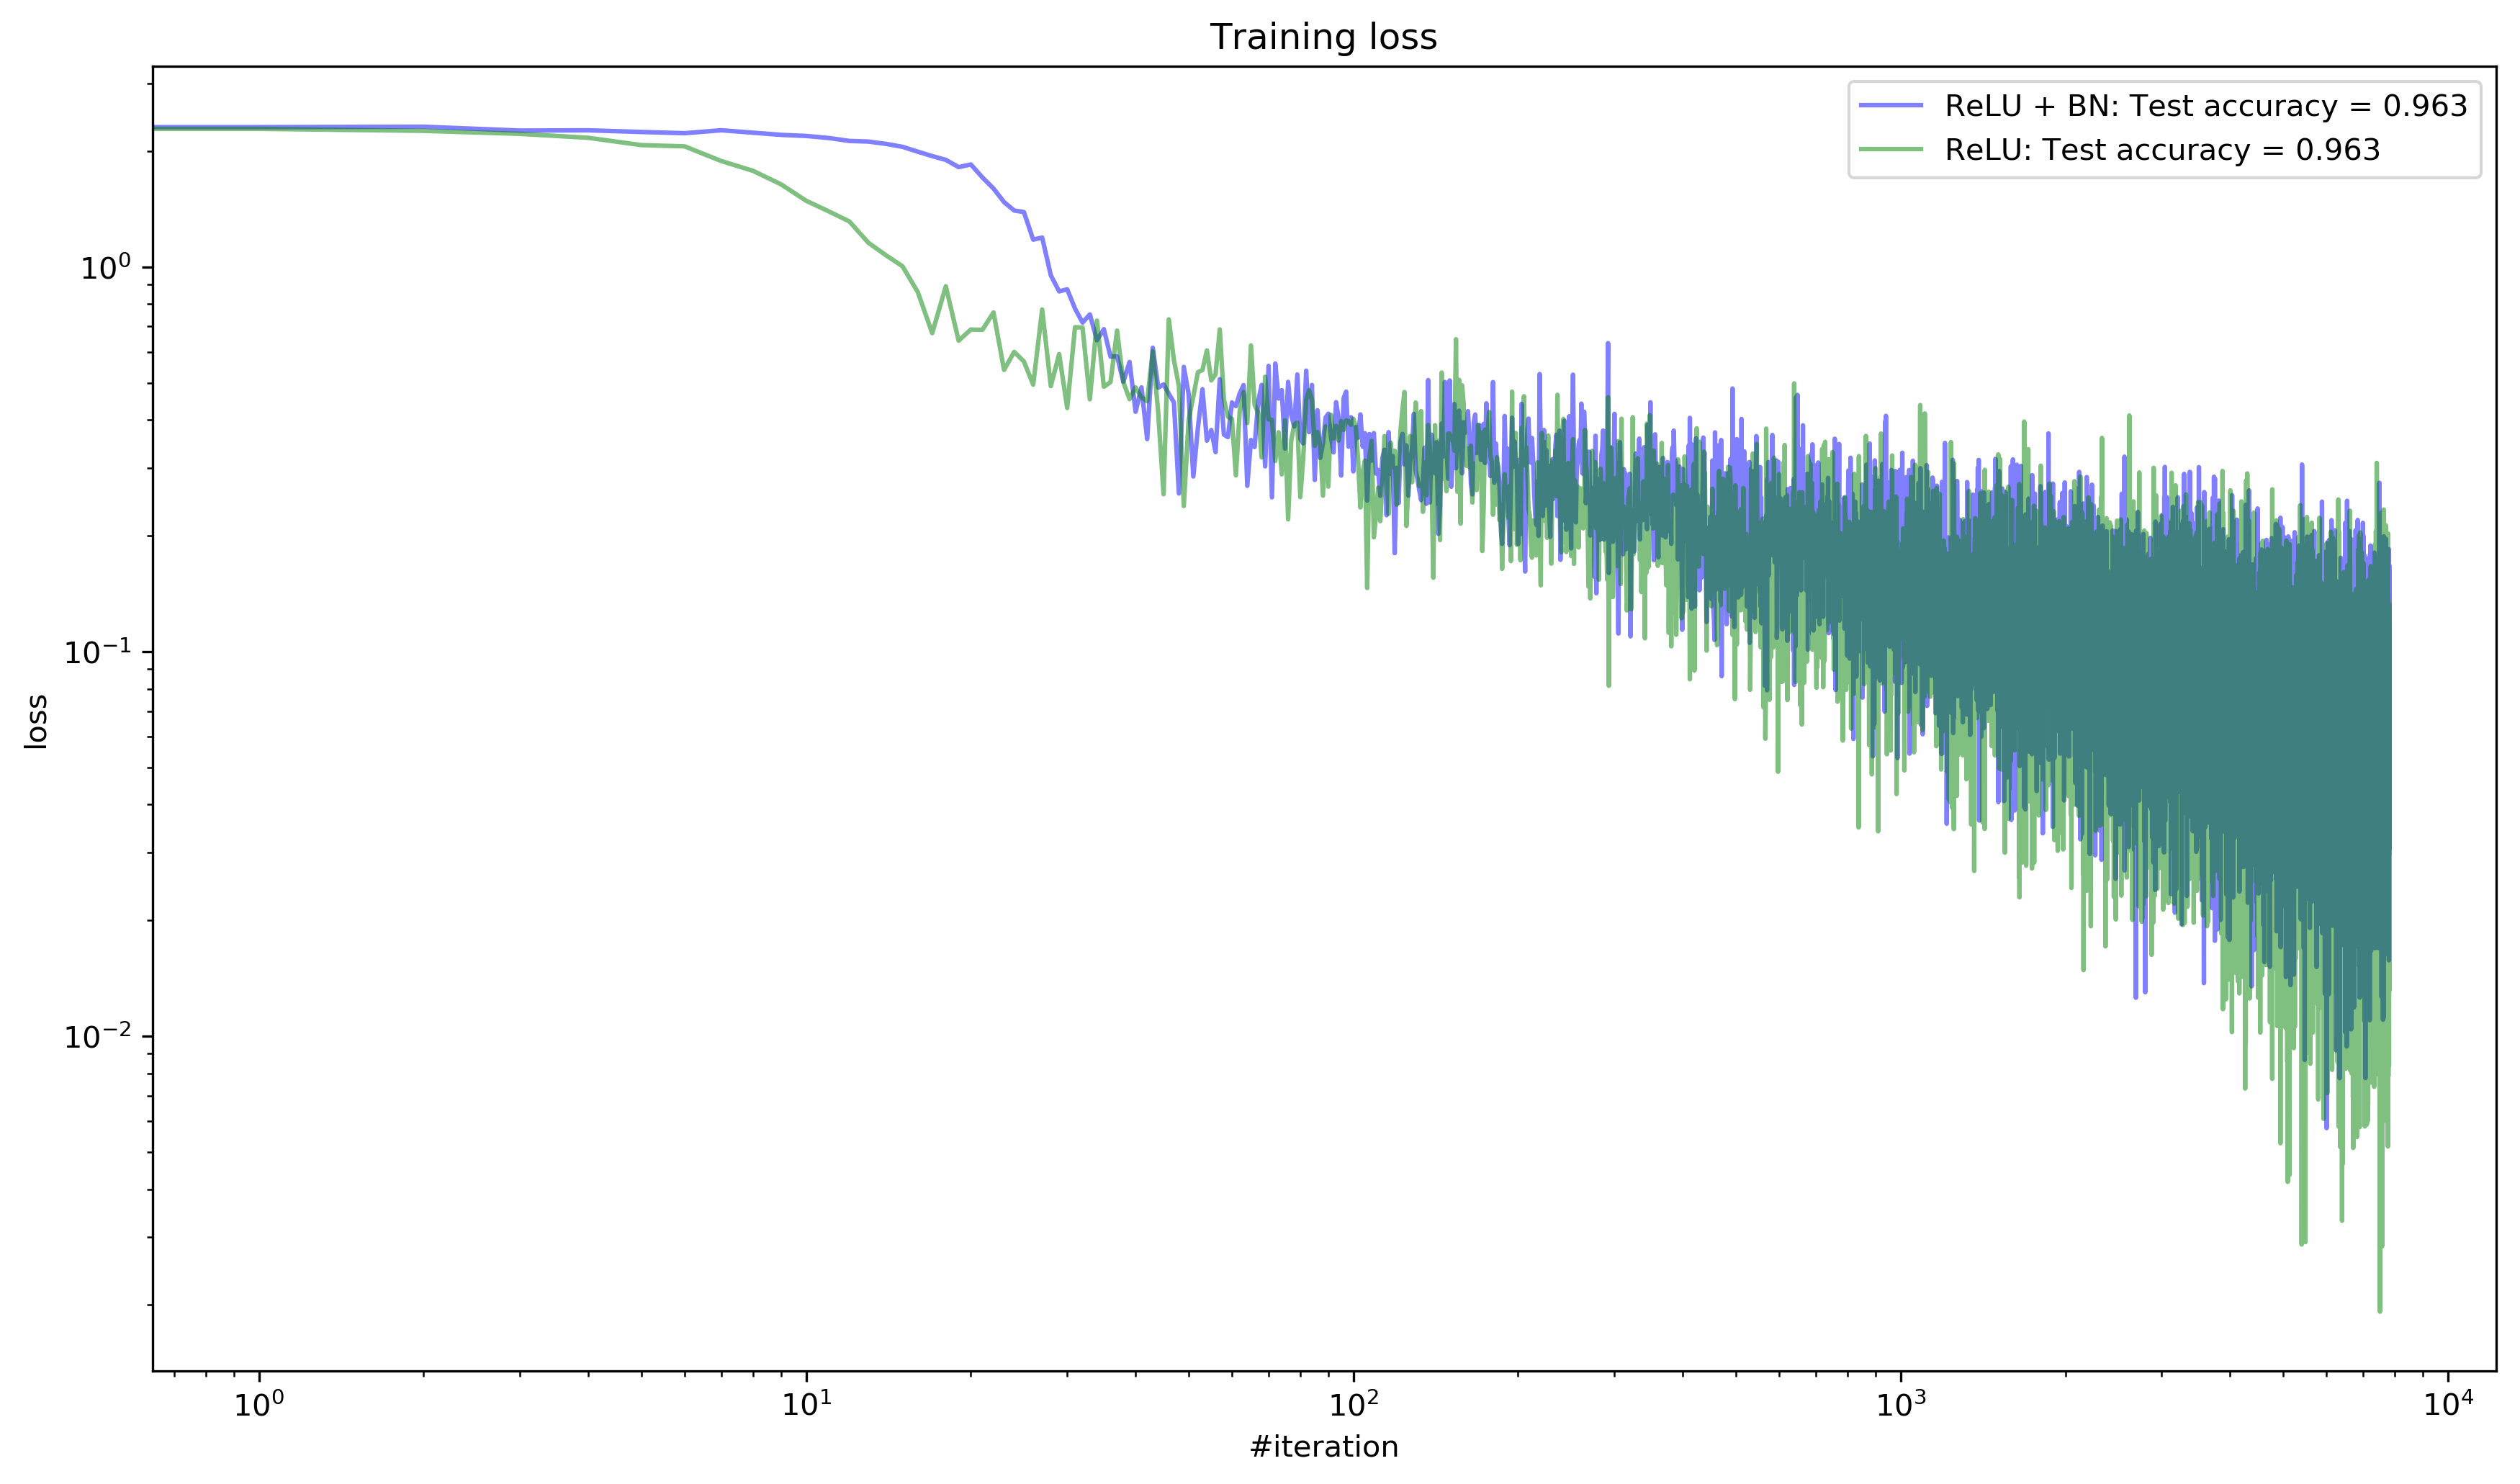

In [20]:
from tqdm import tqdm
loss_history_5 = []

for i in tqdm(range(n_epoch)):
    for x_batch, y_batch in get_batches((X_train, y_train_enc), batch_size):
        
        test5.zeroGradParameters()
        
        # Forward
        predictions = test5.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        test5.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(test5.getParameters(), 
                     test5.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history_5.append(loss)

    y_pred_5 = np.argmax(test5.forward(X_test), axis=1)
    acc_5 = np.mean(y_pred_5 == y_test)

    # Visualize
display.clear_output(wait=True)
plt.figure(figsize=(14, 8), dpi=300)
plt.yscale('log')
plt.xscale('log')
plt.plot(loss_history_5, 'b', label = 'ReLU + BN: Test accuracy = %0.3f' % acc_5, alpha=0.5)
plt.plot(loss_history_1, 'g', label = 'ReLU: Test accuracy = %0.3f' % acc_5, alpha=0.5)
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.legend();

Based on the graph, batch normalization does impove the results, especially at the beginning of the iteration process.

### Part 3: Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better? 

In [21]:
criterion = ClassNLLCriterion()

test7 = Sequential()
test7.add(Flatten())
test7.add(Linear(784, 28))
test7.add(BatchNormalization(alpha = 0.99))
test7.add(ChannelwiseScaling(28))
test7.add(ReLU())
test7.add(Linear(28, 10))
test7.add(LogSoftMax())

In [22]:
# Iptimizer params
optimizer_config_momentum_sgd = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state_sgd = {}

# Looping params
n_epoch = 20
batch_size = 128

In [23]:
loss_history_7 = []

for i in tqdm(range(n_epoch)):
    for x_batch, y_batch in get_batches((X_train, y_train_enc), batch_size):
        
        test7.zeroGradParameters()
        
        # Forward
        predictions = test7.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        test7.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(test7.getParameters(), 
                     test7.getGradParameters(), 
                     optimizer_config_momentum_sgd,
                     optimizer_state_sgd)      
        
        loss_history_7.append(loss)

    y_pred_7 = np.argmax(test7.forward(X_test), axis=1)
    acc_7 = np.mean(y_pred_7 == y_test)

    # Visualize
#     display.clear_output(wait=True)
#     plt.figure(figsize=(8, 6))
        
#     plt.title("Training loss")
#     plt.xlabel("#iteration")
#     plt.ylabel("loss")
#     plt.plot(loss_history, 'b')
#     plt.show()
    
print('Current loss: %f' % loss)
print('Accuracy: %f' % acc_7)

100%|██████████| 20/20 [00:10<00:00,  1.99it/s]

Current loss: 0.176526
Accuracy: 0.957600


In [24]:
criterion = ClassNLLCriterion()

test6 = Sequential()
test6.add(Flatten())
test6.add(Linear(784, 28))
test6.add(BatchNormalization(alpha = 0.99))
test6.add(ChannelwiseScaling(28))
test6.add(ReLU())
test6.add(Linear(28, 10))
test6.add(LogSoftMax())

In [25]:
# Iptimizer params
optimizer_config_adam = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.995, 'epsilon':1e-8}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [26]:
loss_history_6 = []

for i in tqdm(range(n_epoch)):
    for x_batch, y_batch in get_batches((X_train, y_train_enc), batch_size):
        
        test6.zeroGradParameters()
        
        # Forward
        predictions = test6.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        test6.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(test6.getParameters(), 
                     test6.getGradParameters(), 
                     optimizer_config_adam,
                     optimizer_state)      
        
        loss_history_6.append(loss)

    y_pred_6 = np.argmax(test6.forward(X_test), axis=1)
    acc_6 = np.mean(y_pred_6 == y_test)

    # Visualize
#     display.clear_output(wait=True)
#     plt.figure(figsize=(8, 6))
        
#     plt.title("Training loss")
#     plt.xlabel("#iteration")
#     plt.ylabel("loss")
#     plt.plot(loss_history, 'b')
#     plt.show()
    
print('Current loss: %f' % loss)
print('Accuracy: %f' % acc_6)

100%|██████████| 20/20 [00:11<00:00,  1.74it/s]

Current loss: 0.084883
Accuracy: 0.963200


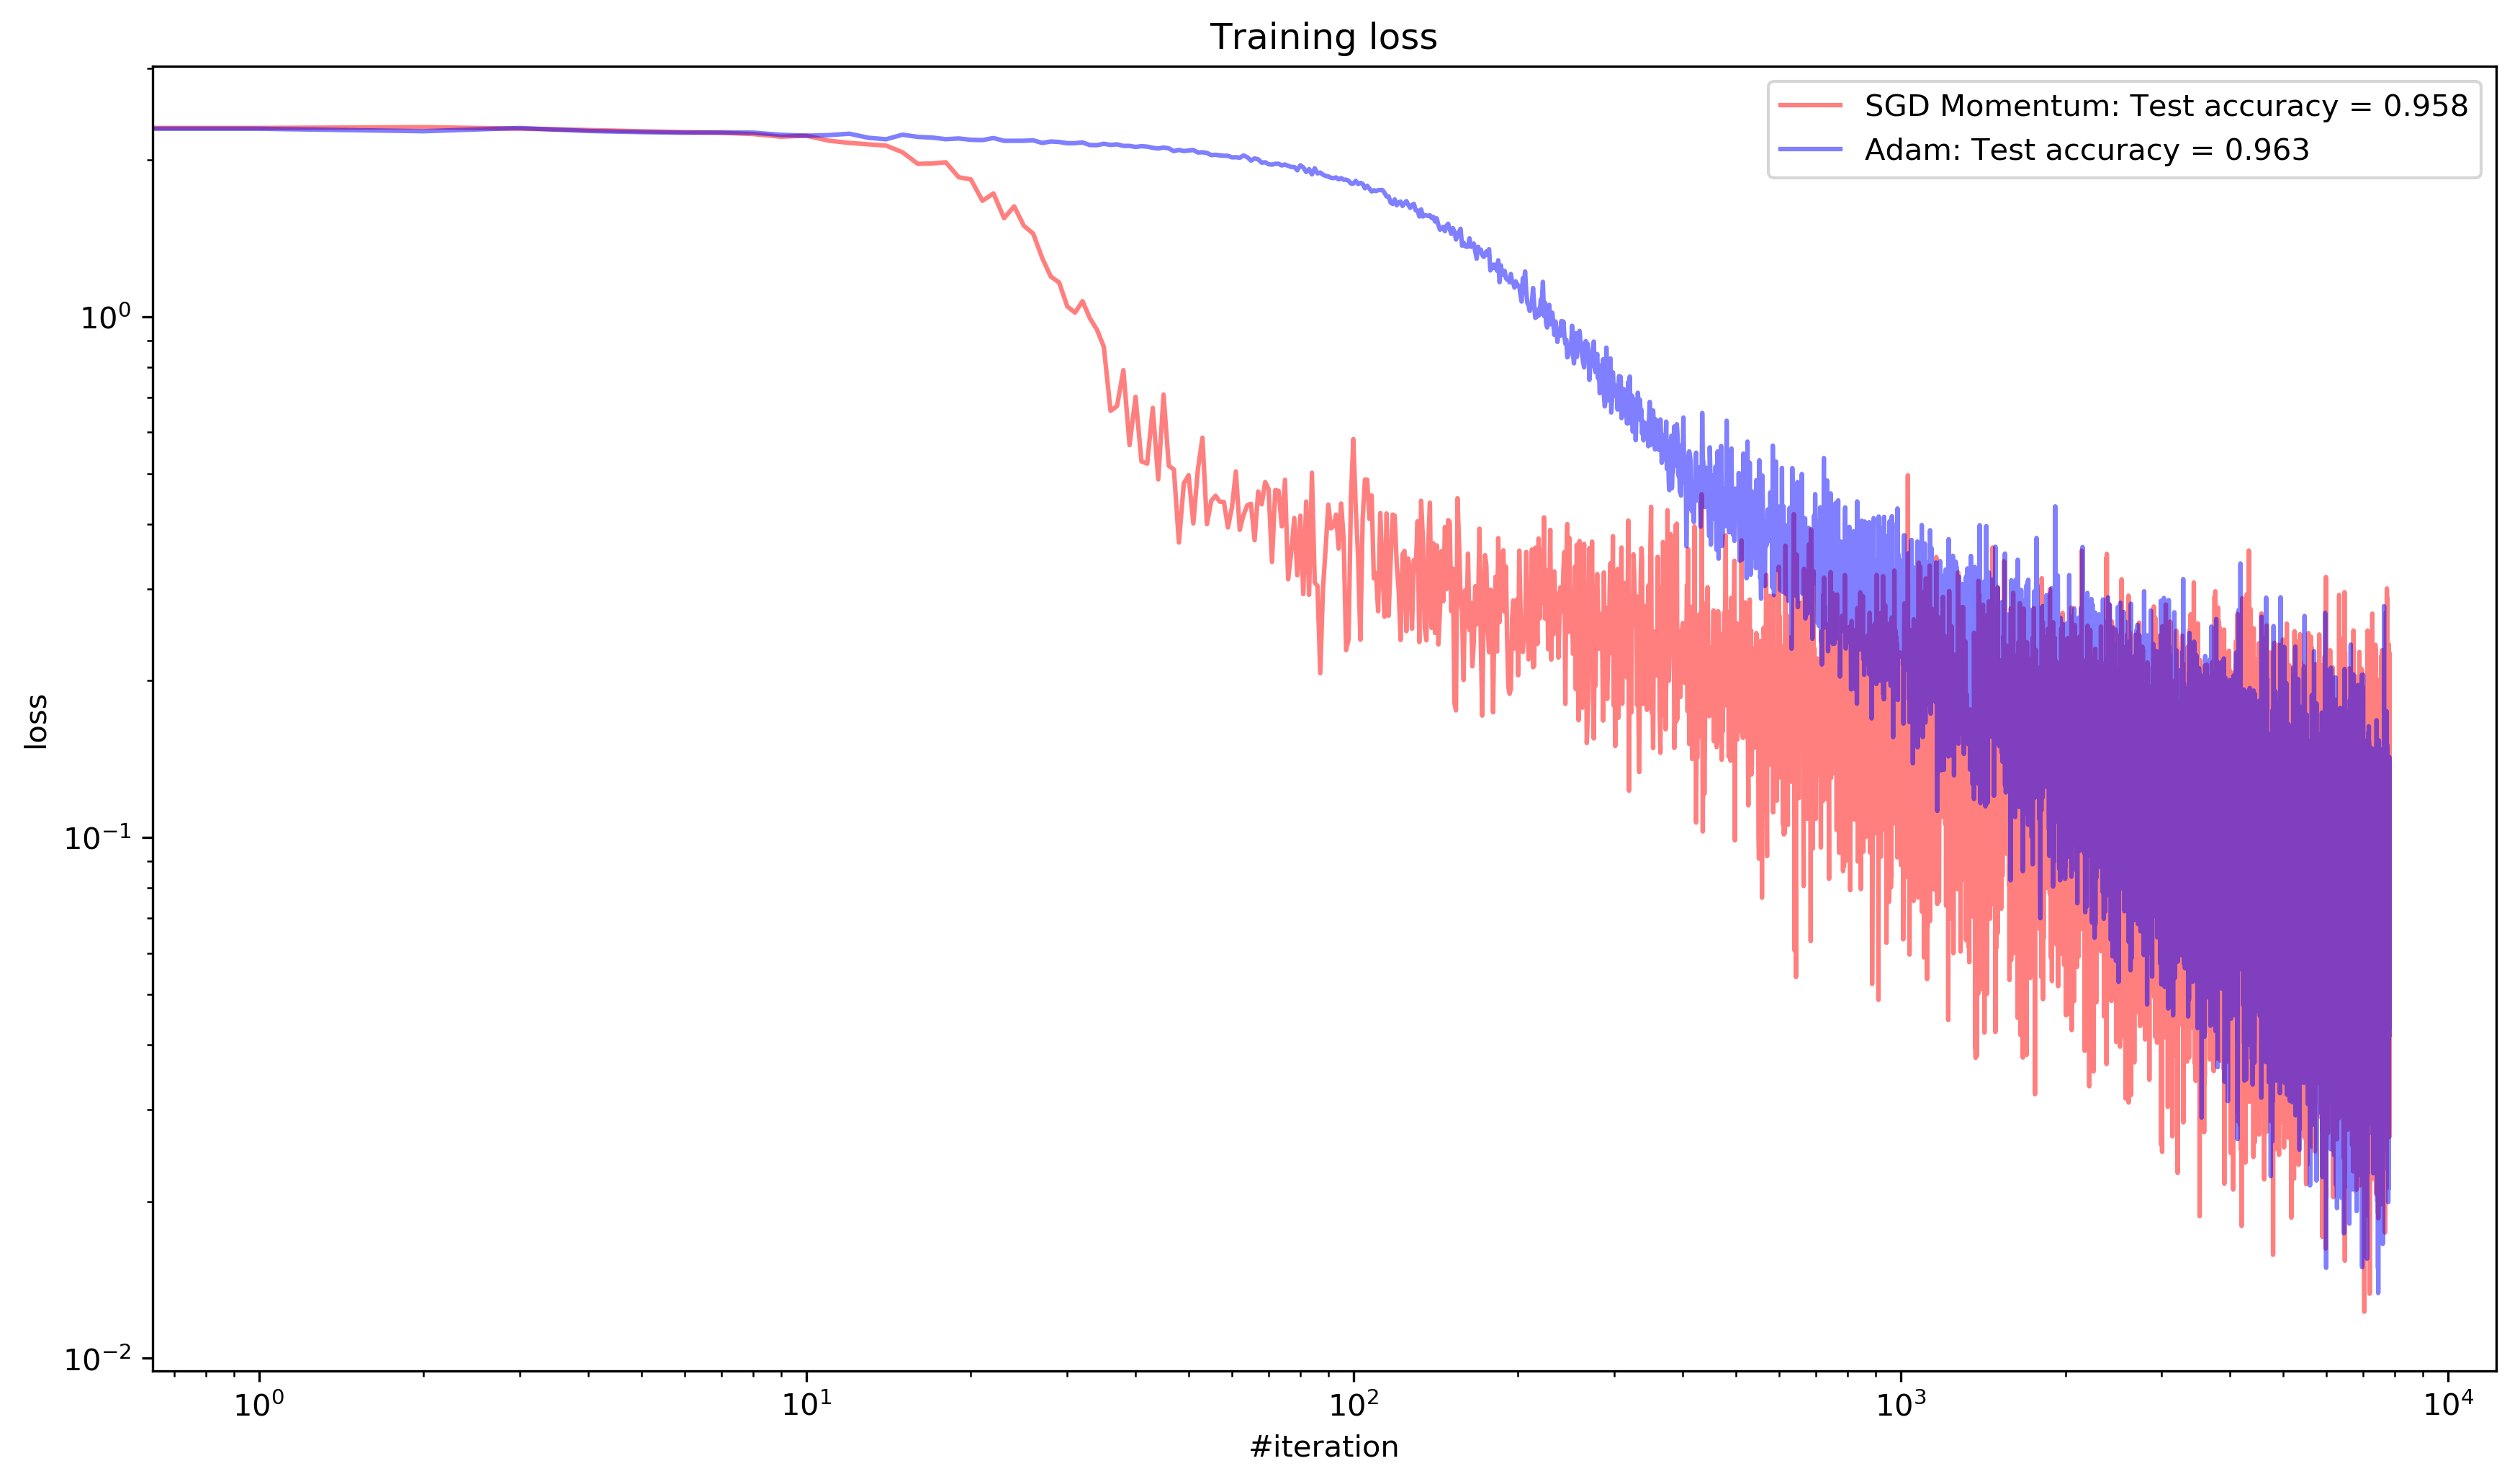

In [27]:
display.clear_output(wait=True)
plt.figure(figsize=(14, 8), dpi=300)
plt.yscale('log')
plt.xscale('log')
plt.plot(loss_history_7, 'r', label = 'SGD Momentum: Test accuracy = %0.3f' % acc_7, alpha=0.5)
plt.plot(loss_history_6, 'b', label = 'Adam: Test accuracy = %0.3f' % acc_6, alpha=0.5)
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.legend();

Based on the graph, SGD Momentum performs worse than Adam.

### Part 3: Increase the number of parameters in the network. Try inserting the Dropout layer.

In [28]:
criterion = ClassNLLCriterion()

test8 = Sequential()
test8.add(Flatten())
test8.add(Linear(784, 28))
test8.add(BatchNormalization(alpha = 0.99))
test8.add(ChannelwiseScaling(28))
test8.add(ReLU())
test8.add(Dropout())
test8.add(Linear(28, 10))
test8.add(LogSoftMax())

In [29]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [30]:
from tqdm import tqdm
loss_history_8 = []

for i in tqdm(range(n_epoch)):
    for x_batch, y_batch in get_batches((X_train, y_train_enc), batch_size):
        
        test8.zeroGradParameters()
        
        # Forward
        predictions = test8.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        test8.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(test8.getParameters(), 
                     test8.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history_8.append(loss)

    y_test_8 = np.argmax(test8.forward(X_test), axis=1)
    acc_8 = np.mean(y_test_8 == y_test)
    
print('Current loss: %f' % loss)
print('Accuracy: %f' % acc_8)

100%|██████████| 20/20 [00:12<00:00,  1.67it/s]

Current loss: 0.733865
Accuracy: 0.815800


In [31]:
criterion = ClassNLLCriterion()

test9 = Sequential()
test9.add(Flatten())
test9.add(Linear(784, 28))
test9.add(BatchNormalization(alpha = 0.99))
test9.add(ChannelwiseScaling(28))
test9.add(ReLU())
test9.add(Dropout())
test9.add(Linear(28, 10))
test9.add(LogSoftMax())

In [32]:
from tqdm import tqdm
loss_history_9 = []

for i in tqdm(range(n_epoch)):
    for x_batch, y_batch in get_batches((X_train, y_train_enc), batch_size):
        
        test9.zeroGradParameters()
        
        # Forward
        predictions = test9.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        test9.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(test9.getParameters(), 
                     test9.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history_9.append(loss)

    y_val_9 = np.argmax(test9.forward(X_val), axis=1)
    acc_9_val = np.mean(y_val_9 == y_val)
    
print('Current loss: %f' % loss)
print('Accuracy: %f' % acc_9_val)

100%|██████████| 20/20 [00:12<00:00,  1.68it/s]

Current loss: 0.358231
Accuracy: 0.856300


In [33]:
criterion = ClassNLLCriterion()

test10 = Sequential()
test10.add(Flatten())
test10.add(Linear(784, 28))
test10.add(BatchNormalization(alpha = 0.99))
test10.add(ChannelwiseScaling(28))
test10.add(ReLU())
test10.add(Linear(28, 10))
test10.add(LogSoftMax())

In [34]:
from tqdm import tqdm
loss_history_10 = []

for i in tqdm(range(n_epoch)):
    for x_batch, y_batch in get_batches((X_train, y_train_enc), batch_size):
        
        test10.zeroGradParameters()
        
        # Forward
        predictions = test10.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        test10.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(test10.getParameters(), 
                     test10.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history_10.append(loss)

    y_val_10 = np.argmax(test10.forward(X_val), axis=1)
    acc_10_val = np.mean(y_val_10 == y_val)
    
print('Current loss: %f' % loss)
print('Accuracy: %f' % acc_10_val)

100%|██████████| 20/20 [00:10<00:00,  1.76it/s]

Current loss: 0.033209
Accuracy: 0.966400


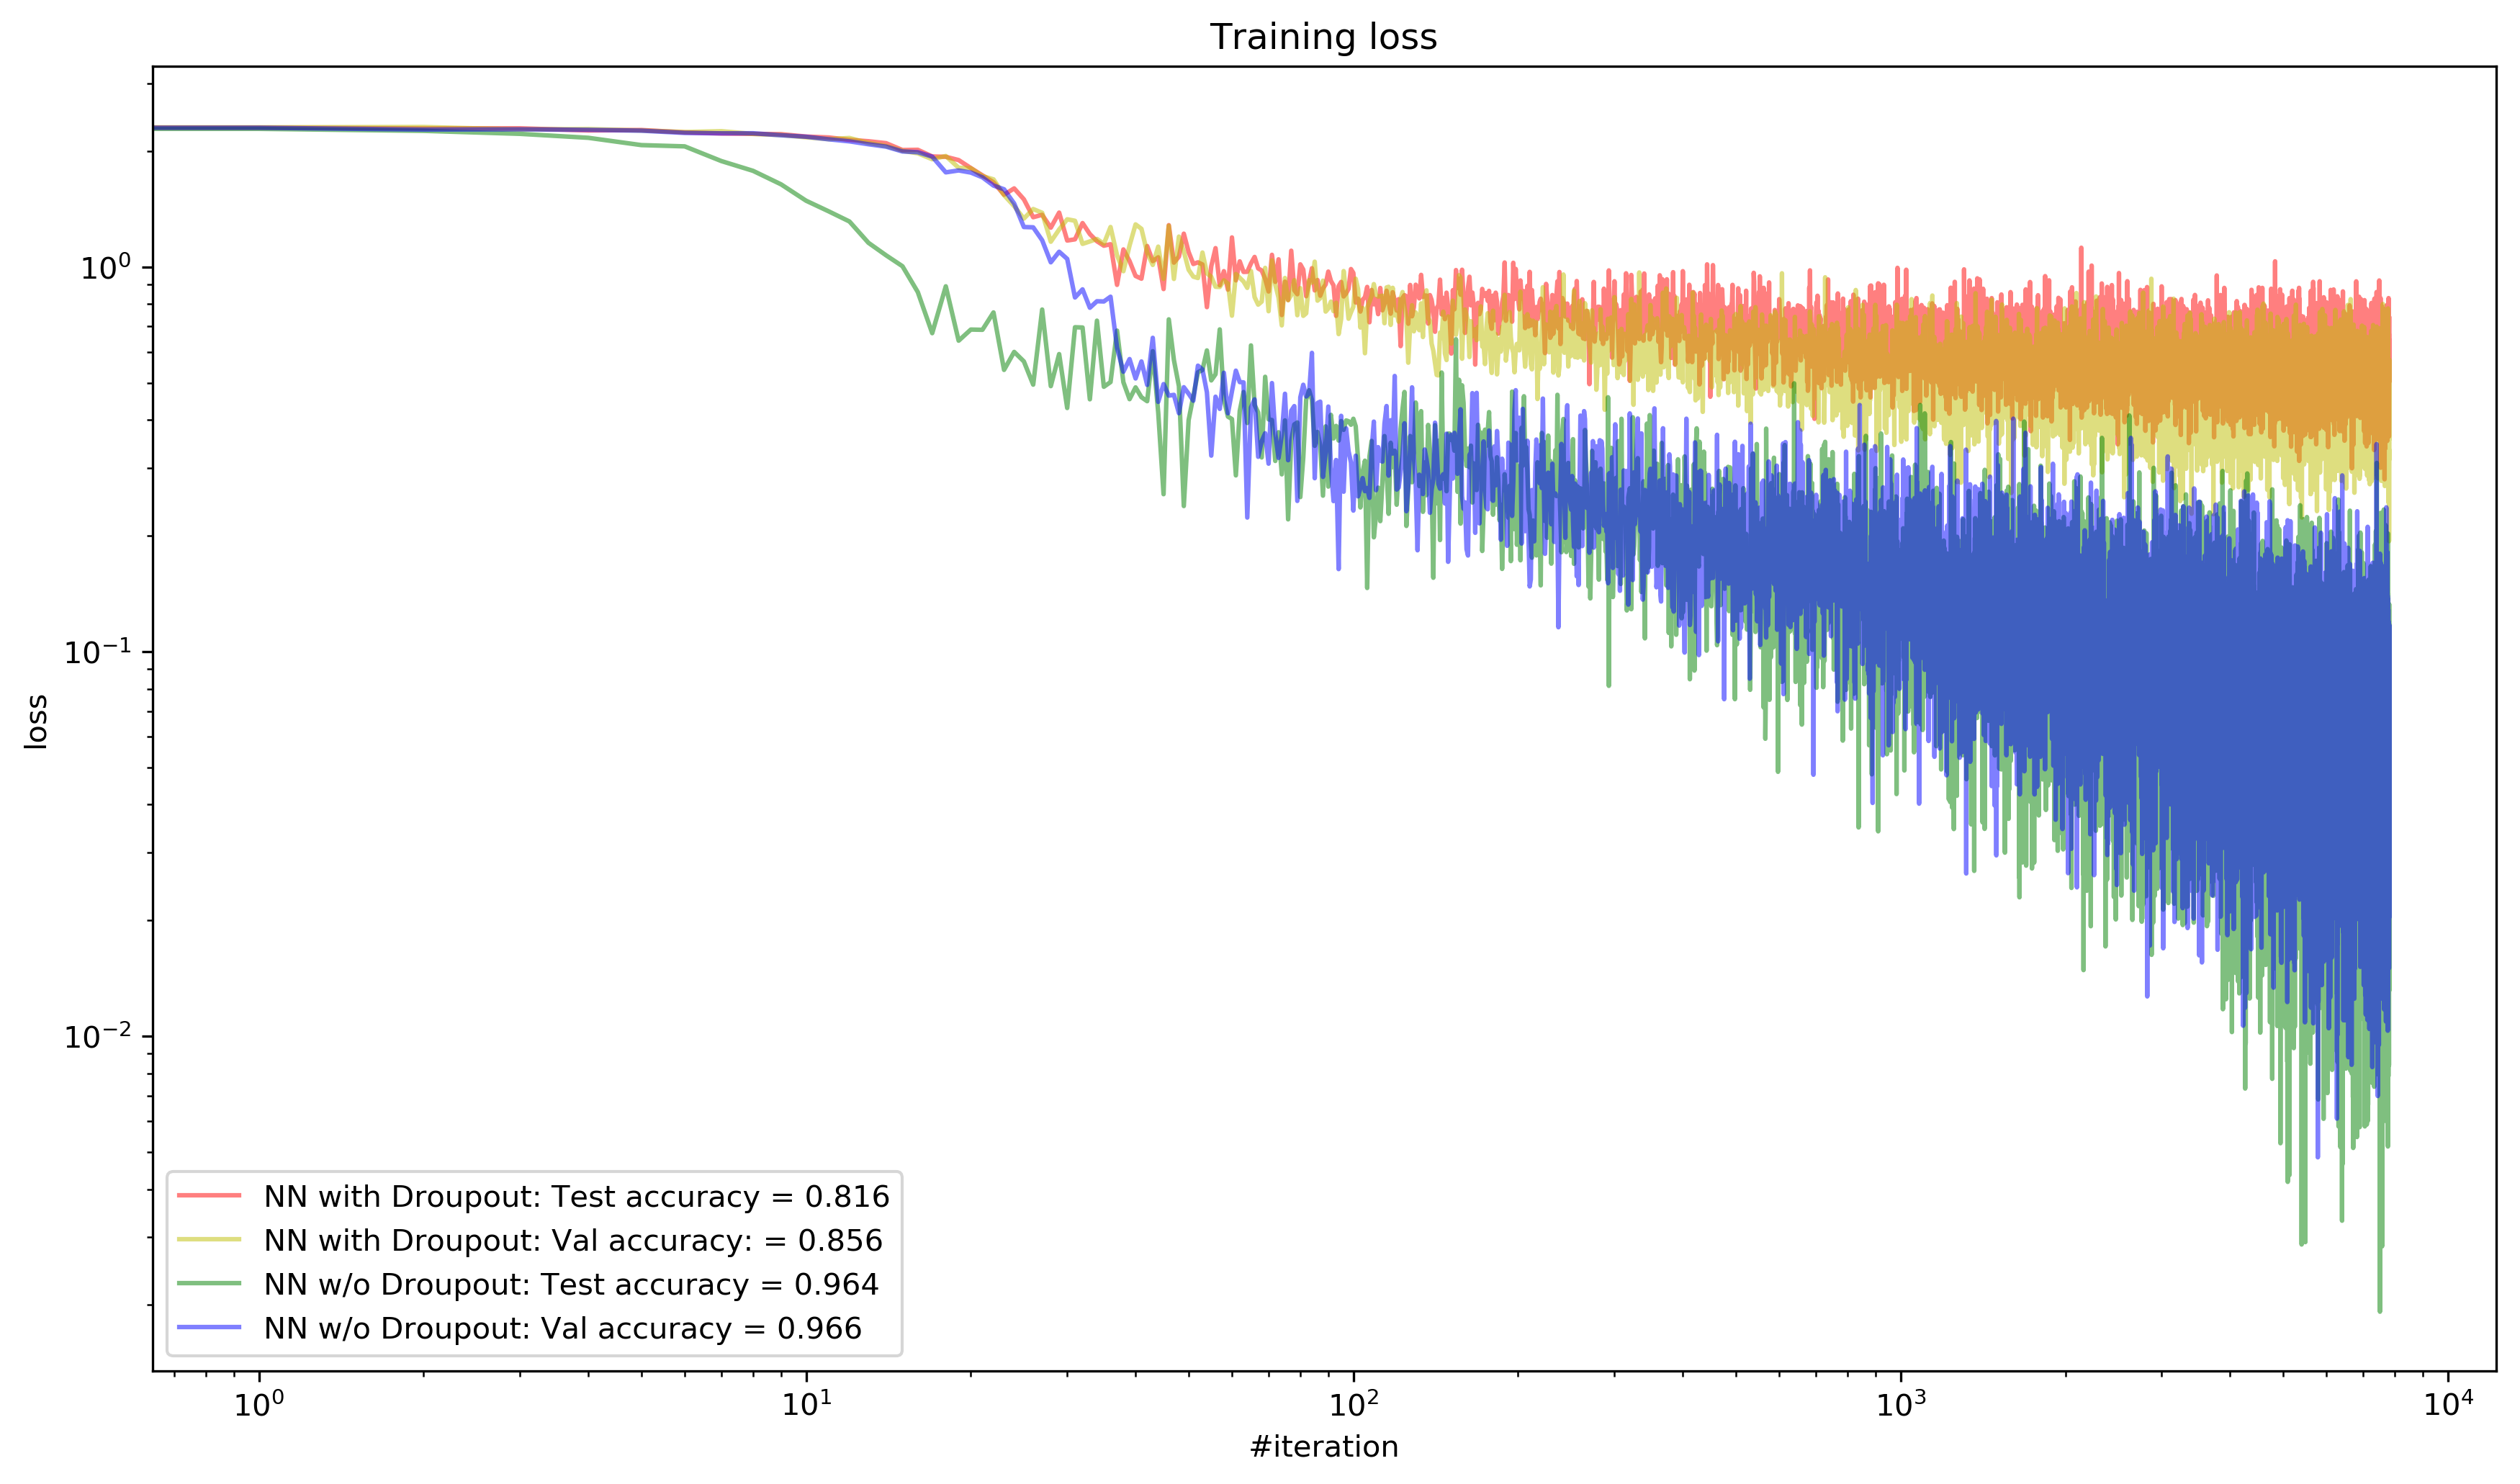

In [35]:
display.clear_output(wait=True)
plt.figure(figsize=(14, 8), dpi=300)
plt.yscale('log')
plt.xscale('log')
plt.plot(loss_history_8, 'r', label = 'NN with Droupout: Test accuracy = %0.3f' % acc_8, alpha=0.5)
plt.plot(loss_history_9, 'y', label = 'NN with Droupout: Val accuracy: = %0.3f' % acc_9_val, alpha=0.5)
plt.plot(loss_history_1, 'g', label = 'NN w/o Droupout: Test accuracy = %0.3f' % acc_1, alpha=0.5)
plt.plot(loss_history_10, 'b', label = 'NN w/o Droupout: Val accuracy = %0.3f' % acc_10_val, alpha=0.5)
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.legend();

Slower convergence for droupout.

# Learning embeddings

**Finally**, use the Contrastive criterion instead of the NLLCriterion to train the embeddings. 
Using the code below, compute the pairwise distances and show the distance histograms for the validation set (or its part). Compute the Bhattacharyya coefficient using the outputs of the plt.hist: $ BC(p,q) = \sum (\sqrt{p_i q_i}) $.

Repeat this for the embeddings trained with the NLLCriterion, compare the results. You may want to try different margins $M$ (hint: $M=10$ should be okay).

 ***3 points***

In [36]:
#features : 'number of examples' * 'dimensionality'
f = #<YOUR CODE GOES HERE>

import scipy.spatial
#compute pairwise distances
d = scipy.spatial.distance_matrix(f,f)
#extract distances for the 'positive pairs' (same class), 
#extract distances for the 'negarite pairs' (different classes), 
a = np.tile(labels.reshape(len(labels), 1), (1, len(labels)))
b =np.tile(labels.reshape(1, len(labels)), (len(labels), 1))
#labels
c = np.zeros((len(labels), len(labels)))
c[a==b]=1
pind =  np.triu(c, k=1)

c = np.zeros((len(labels), len(labels)))
c[a!=b]=1
nind =  np.triu(c, k=1)

print(np.sum(pind), np.sum(nind))


pd = d[pind == 1]
nd = d[nind == 1]

hp,_,_ =plt.hist(pd, bins=100, color='green', alpha = 0.3, weights = np.ones(len(pd))/len(pd), label = 'distances for positive pairs')
hn,_,_ =plt.hist(nd, bins=100, color='red', alpha = 0.3, weights = np.ones(len(nd))/len(nd),label = 'distances for negative pairs')
plt.legend(loc='best')

bhattacharyya = np.sum(np.sqrt(hp*hn))

SyntaxError: invalid syntax (<ipython-input-36-36bc467dc788>, line 2)